## Intall Dependencies

In [1]:
!nvidia-smi

Thu Sep 28 10:06:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Clone YOLOv5 repositiry

!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15997, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 15997 (delta 19), reused 18 (delta 12), pack-reused 15967
Receiving objects: 100% (15997/15997), 14.65 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (10985/10985), done.
/content/yolov5


In [3]:
# install dependencies as necessary
!pip install -qr requirements.txt # install dependencies (ignore errors)

import torch

from IPython.display import Image, clear_output # to display images
#from utils.google_utils import gdrive_download # to download models/datasets

# clear_output()

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
Setup complete. Using torch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


## Your Custom Data

In [4]:
pwd

'/content/yolov5'

In [5]:
%cd /content

/content


In [6]:
import gdown

url = "https://drive.google.com/file/d/1ktbSiEpbbwVgCTgMlV9CoZtlYtY3yjjz/view?usp=sharing"

file_id = url.split("/")[-2]

print(file_id)

#download string
prefix = 'https://drive.google.com/uc?/export=download&id='


gdown.download(prefix+file_id)
print("Data downloaded")


1ktbSiEpbbwVgCTgMlV9CoZtlYtY3yjjz


Downloading...
From: https://drive.google.com/uc?/export=download&id=1ktbSiEpbbwVgCTgMlV9CoZtlYtY3yjjz
To: /content/waste_data.zip
100%|██████████| 117k/117k [00:00<00:00, 2.77MB/s]

Data downloaded


In [7]:
!unzip waste_data.zip

Archive:  waste_data.zip
  inflating: data.yaml               
  inflating: train/images/banana.jpg  
  inflating: train/images/book.webp  
  inflating: train/images/eated banana.webp  
  inflating: train/images/soft drink.webp  
  inflating: train/labels/banana.txt  
  inflating: train/labels/book.txt   
  inflating: train/labels/classes.txt  
  inflating: train/labels/eated banana.txt  
  inflating: train/labels/soft drink.txt  
  inflating: valid/images/banana.jpg  
  inflating: valid/images/book.webp  
  inflating: valid/images/eated banana.webp  
  inflating: valid/images/soft drink.webp  
  inflating: valid/labels/banana.txt  
  inflating: valid/labels/book.txt   
  inflating: valid/labels/eated banana.txt  
  inflating: valid/labels/soft drink.txt  


In [8]:
# remove the zip file
!rm -rf waste_data.zip

In [9]:
# This is the YAML file we're loading into this notebook with our data

%cat data.yaml # cat coment is used for read the file

train: ../train/images
val: ../valid/images


nc: 20
names: ['dog','person','cat','tv','car','meatballs','marinara sauce','tomato soup','chicken noodle soup','french onion soup','chicken breast','ribs','pulled pork','hamburger','cavity','book','soft drink','eated banana','banana','soft drink can']

## Define Model Configuration And Architecture

In [10]:
# Extact the data from ymal

import yaml
with open("data.yaml","r") as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])



In [11]:
num_classes

'20'

In [12]:
# Train yolo v5 model
# prepare model configuration


%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, AGPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]

In [13]:
# customize Ipython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

Help to use change th classes

In [18]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml


# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]




In [19]:
changed the num of classes to 20

%cat  /content/yolov5/models/custom_yolov5s.yaml



# Parameters
nc: 20  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, 

## Train Custom YOLOv5 Detector

Next we'll fire off training!

Here, we are able to pass a number of arguments:


-  img : define input image size
- batch : determine batch size
- epochs : define the number of training epochs. (Note: often, 3000+ are common here!)
- data : set the path to our yaml file
- cfg : specify our model configuration
- weights : specify a custom oath to weights.(Note: you can download weights from the Ultalytics google Drive)
- name : result names
- nosave : only save the final checkpoint
- cache : cache images for faster training

In [21]:
# trian yolov5 on custom data for 100 epochs
# time its performance

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml'  --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_

## Evaluate Custom YOLOv5 Detector Performance

In [30]:
# Start tensorboard
# lanch after you have started training
# logs save in the folder "runs"


%load_ext tensorboard
%tensorboard --logdir runs
# %reload_ext tensorboard
!kill 7838

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7838), started 0:00:31 ago. (Use '!kill 7838' to kill it.)

<IPython.core.display.Javascript object>

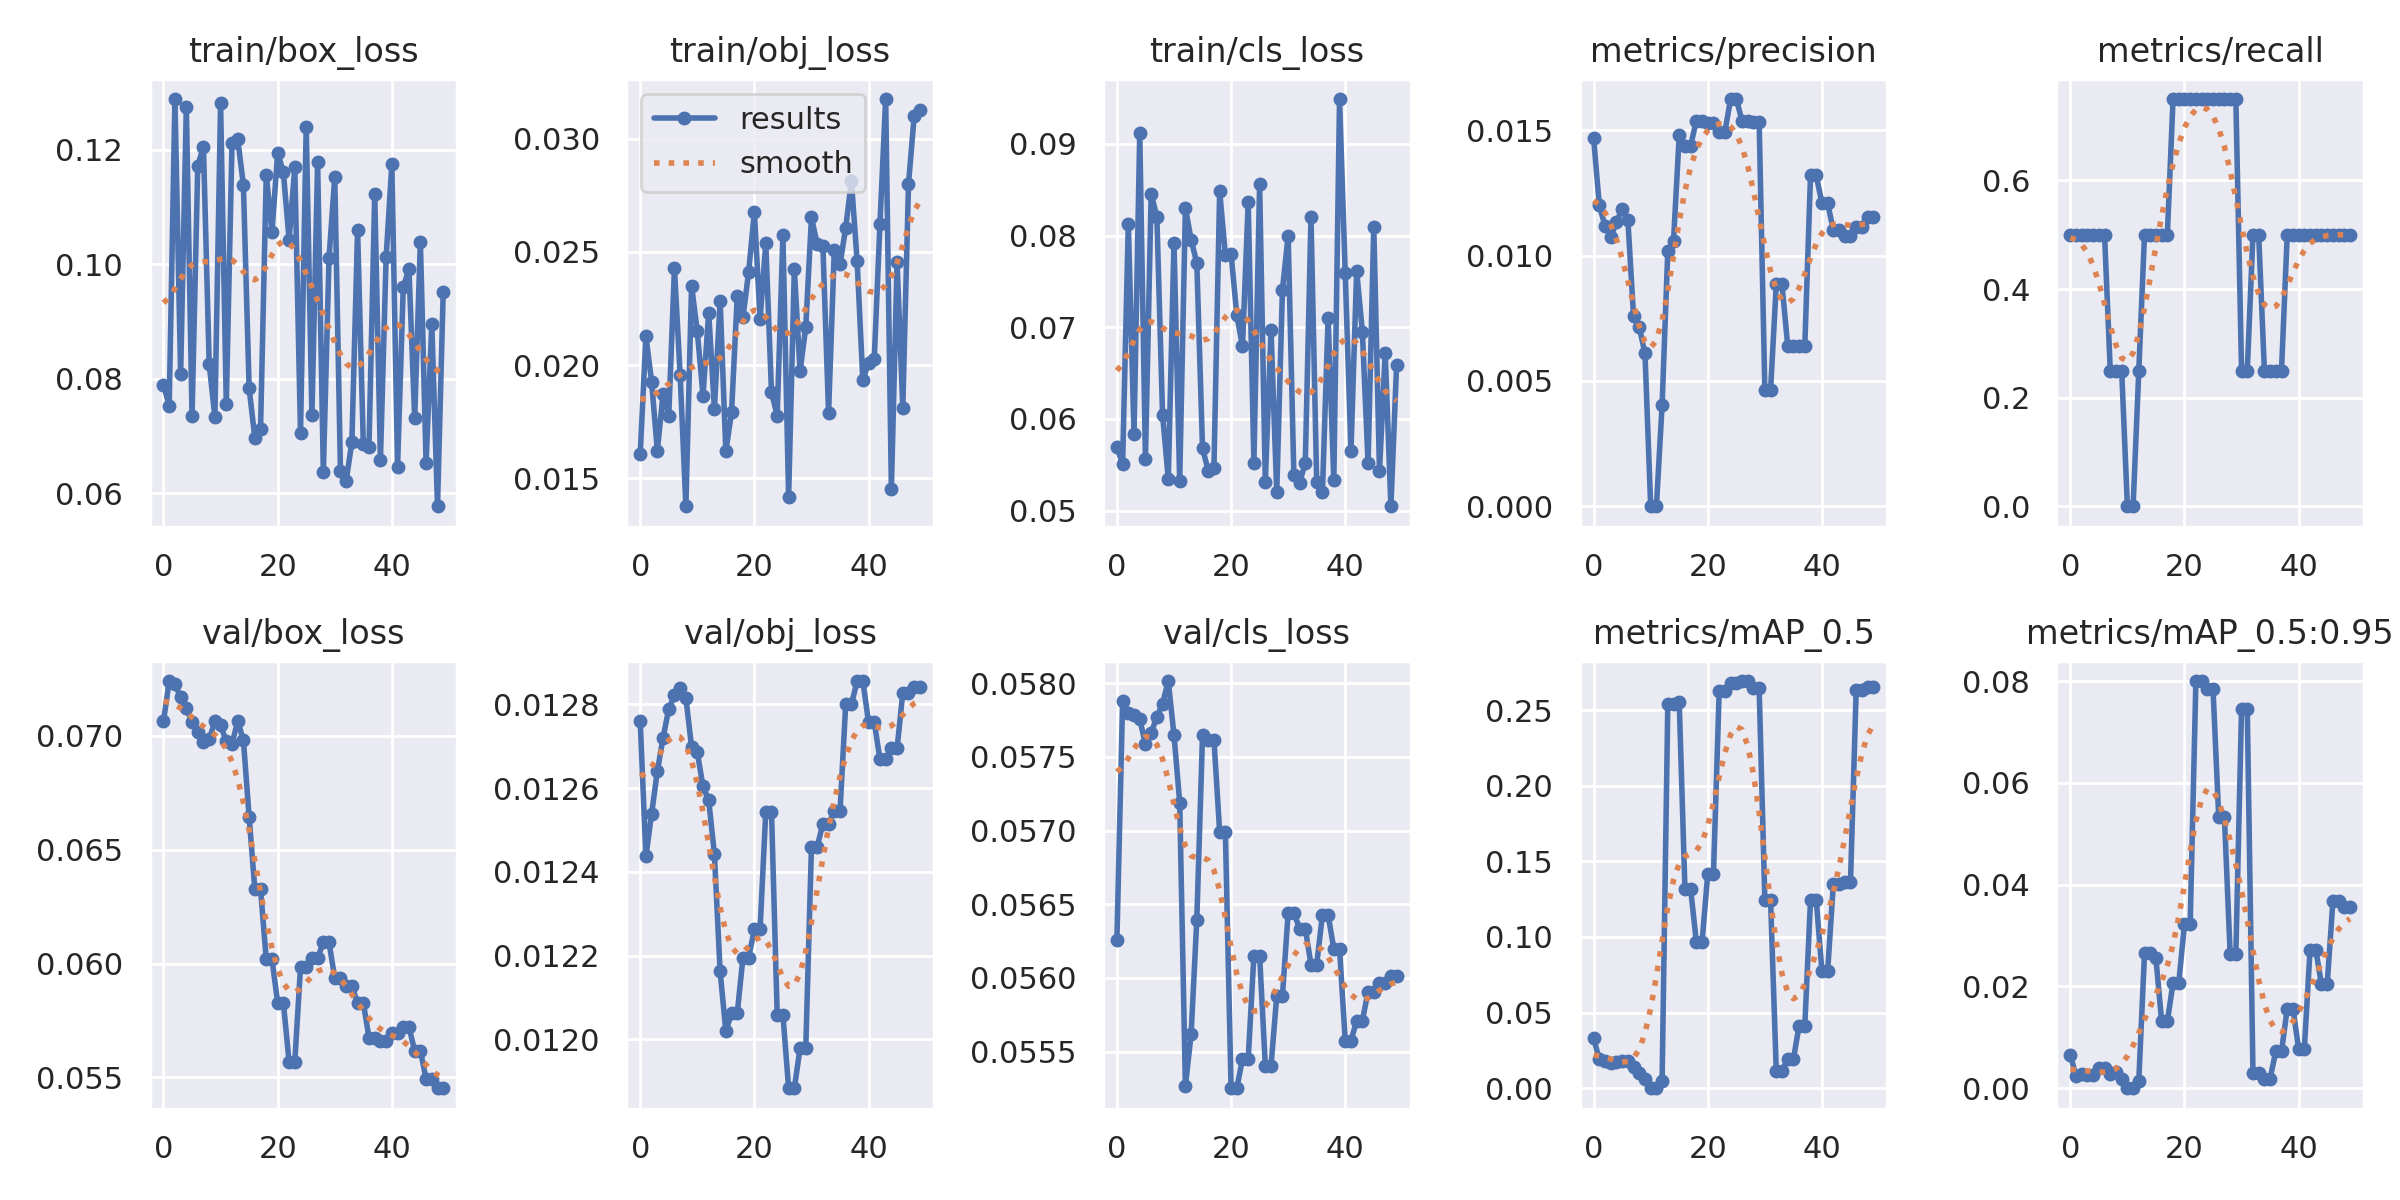

In [32]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results
# plot results.txt as result.png
Image(filename = "/content/yolov5/runs/train/yolov5s_results/results.png",width = 1000) #view result.png

GROUND TRUTH TRAINING DATA:


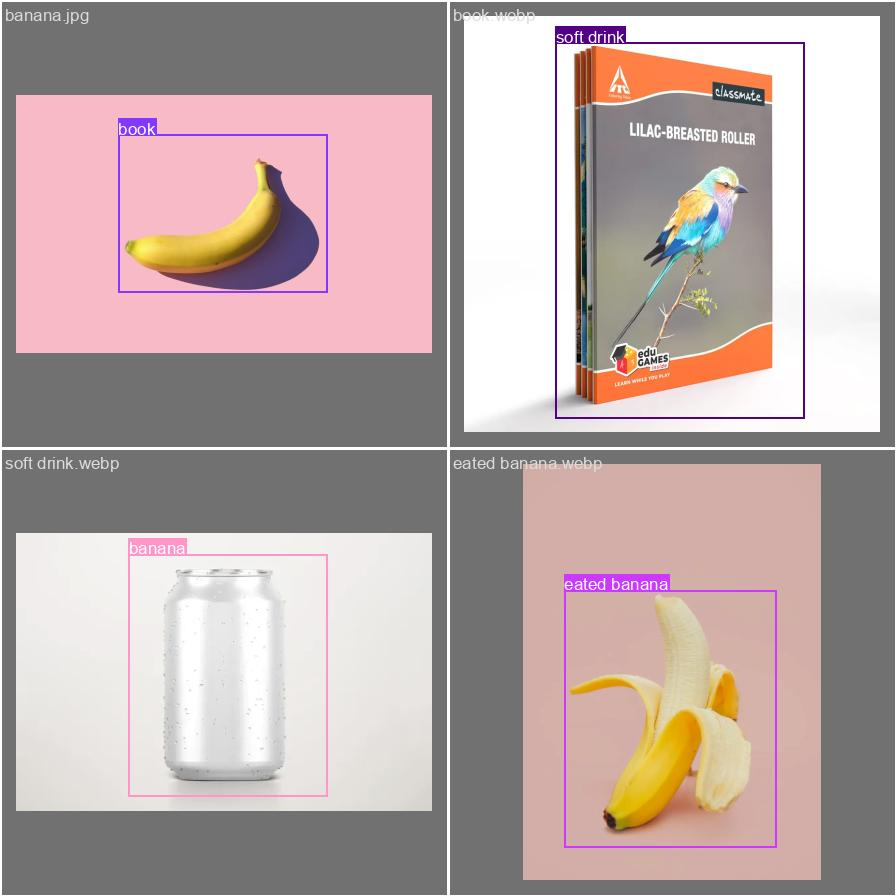

In [34]:
# first, display our ground truth data

print("GROUND TRUTH TRAINING DATA:")

Image(filename = "/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg", width = 900)

GROUND TRUTH TRAINING DATA:


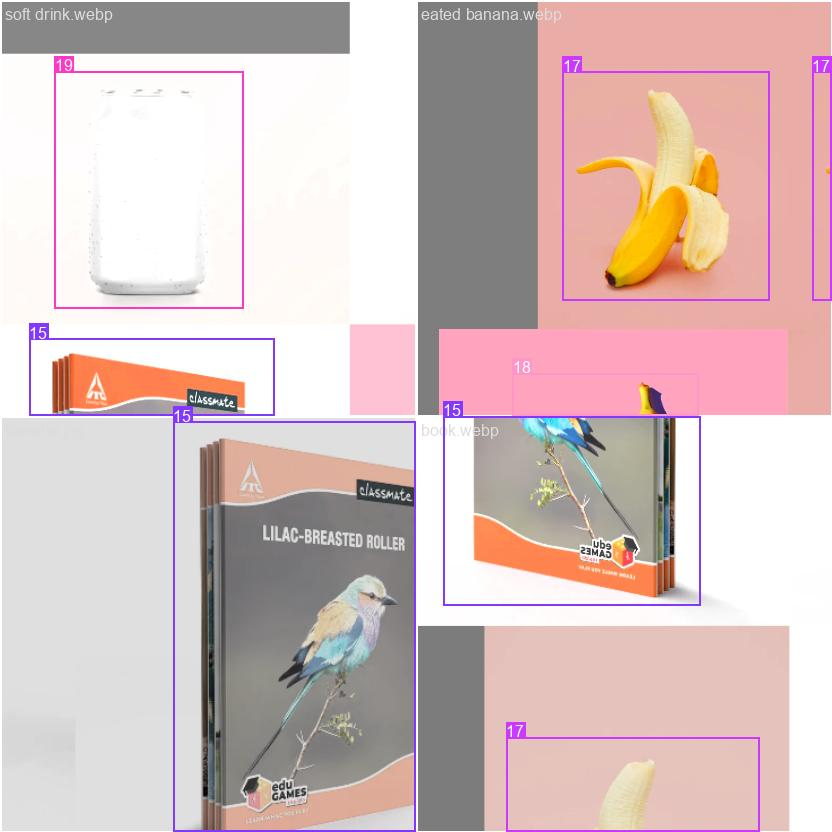

In [35]:
# first, display our ground truth data

print("GROUND TRUTH TRAINING DATA:")

Image(filename = "/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg", width = 900)



## Run Inference with Trained Weights


Run inference with a pretrained checkpoint on contents of test/images folder downloaded from Roboflow

In [36]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [37]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [40]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# Use the best weights!

%cd /content/yolov5/

!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7064065 parameters, 0 gradients, 15.9 GFLOPs
image 1/4 /content/valid/images/banana.jpg: 288x416 (no detections), 42.4ms
image 2/4 /content/valid/images/book.webp: 416x416 (no detections), 7.6ms
image 3/4 /content/valid/images/eated banana.webp: 416x320 (no detections), 43.0ms
image 4/4 /content/valid/images/soft drink.webp: 288x416 (no dete

In [41]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt  /content/drive/MyDrive/Self Projects/DL/Waste Detection

cp: target 'Detection' is not a directory
